<a href="https://colab.research.google.com/github/Rangulov/PhMathInfo/blob/main/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Подготовка датасета

In [1]:
# Импортируем библиотеки

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_palette('husl')
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

In [4]:
dataset = pd.read_csv("Sythetic.csv")

In [5]:
dataset.head()

,x,y,z,target
0,1.295428,0.050829,-0.385217,1
1,1.409178,-0.035191,-0.251980,1
2,1.096803,0.246365,-0.415011,1
3,1.463328,0.265354,-0.513488,1
4,1.603284,0.080577,-0.470257,1


In [6]:
dataset = dataset[['x', 'y', 'z', 'target']].dropna()

In [7]:
dataset.head()

,x,y,z,target
0,1.295428,0.050829,-0.385217,1
1,1.409178,-0.035191,-0.251980,1
2,1.096803,0.246365,-0.415011,1
3,1.463328,0.265354,-0.513488,1
4,1.603284,0.080577,-0.470257,1


In [8]:
dataset.shape

(400, 4)

In [9]:
vals = dataset["target"].unique()
vals

array([1, 2, 3, 4])

In [10]:
cols_for_clusters = ['x', 'y', 'z']

df= dataset[cols_for_clusters].copy() # делаем копию, чтобы не было сюрпризов с исходным набором данных

In [11]:
df.head()

,x,y,z
0,1.295428,0.050829,-0.385217
1,1.409178,-0.035191,-0.251980
2,1.096803,0.246365,-0.415011
3,1.463328,0.265354,-0.513488
4,1.603284,0.080577,-0.470257


In [12]:
X = df
y = dataset["target"].replace(vals, [0, 1, 2, 3])
yvals = dataset["target"]

# K-Means


In [13]:
import mpl_toolkits.mplot3d  # noqa: F401
from sklearn.cluster import KMeans

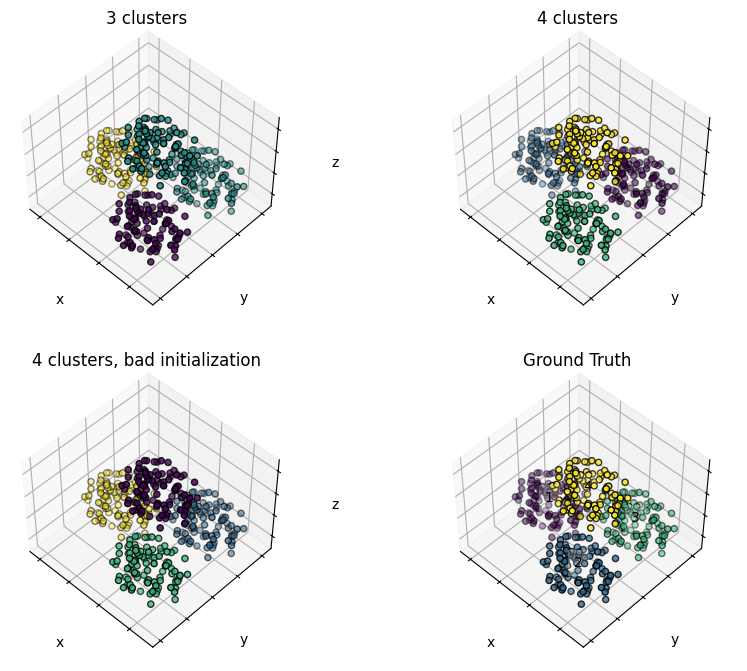

In [14]:
estimators = [
    ("k_means_target_3", KMeans(n_clusters=3)),
    ("k_means_target_4", KMeans(n_clusters=4)),
    ("k_means_target_bad_init", KMeans(n_clusters=4, n_init=1, init="random")),
]

fig = plt.figure(figsize=(10, 8))
titles = ["3 clusters", "4 clusters", "4 clusters, bad initialization"]
for idx, ((name, est), title) in enumerate(zip(estimators, titles)):
    ax = fig.add_subplot(2, 2, idx + 1, projection="3d", elev=48, azim=134)
    est.fit(X)
    labels = est.labels_

    ax.scatter(X["x"], X["y"], X["z"], c=labels.astype(float), edgecolor="k")

    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.set_title(title)

# Plot the ground truth
ax = fig.add_subplot(2, 2, 4, projection="3d", elev=48, azim=134)

for name, label in [(vals[0], 0), (vals[1], 1), (vals[2], 2), (vals[3], 3)]:
    ds = dataset[dataset["target"]==name]
    ax.text3D(
        ds["x"].mean(),
        ds["y"].mean(),
        ds["z"].mean(),
        name,
        horizontalalignment="center",
        bbox=dict(alpha=0.2, edgecolor="w", facecolor="w"),
    )

ax.scatter(X["x"], X["y"], X["z"], c=y, edgecolor="k")

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_title("Ground Truth")

plt.subplots_adjust(wspace=0.25, hspace=0.25)
plt.show()

## Метрики


In [15]:
from sklearn import metrics
from sklearn.metrics.cluster import adjusted_rand_score


n_clusters = np.arange(2, 21)

In [16]:
best_metric = [0, 10000, 0,[]]

silhouette_score_values = []
adjusted_rand_score_values = []


for n in n_clusters:

    clusterer = KMeans(n_clusters=n, max_iter=10, n_init=10)
    clusterer.fit(X)
    y_pred = clusterer.predict(X)

    score1 = metrics.silhouette_score(X, y_pred)
    silhouette_score_values.append(score1)

    score2 = metrics.adjusted_rand_score(y, y_pred)
    adjusted_rand_score_values.append(score2)


    if score1 < best_metric[1] and score2 > best_metric[2]:
          best_metric[1] = score1
          best_metric[2] = score2
          best_metric[3] = clusterer.cluster_centers_
          best_metric[0] = n




In [17]:
best_metric

[np.int64(8),
 np.float64(0.24785907430738485),
 0.598152241572322,
 array([[-0.24452673, -1.01304697, -0.2628529 ],
        [-0.50314887,  0.76606108, -0.68276158],
        [ 0.3741153 ,  0.08823056,  1.54606714],
        [-0.2245187 , -0.26873567,  1.13790858],
        [ 1.44319651, -0.28411351, -0.7036534 ],
        [-0.87785443, -1.36463914, -0.65276064],
        [-0.53488565,  1.32579863, -0.14728656],
        [ 1.34036165,  0.19760096, -0.10714817]])]

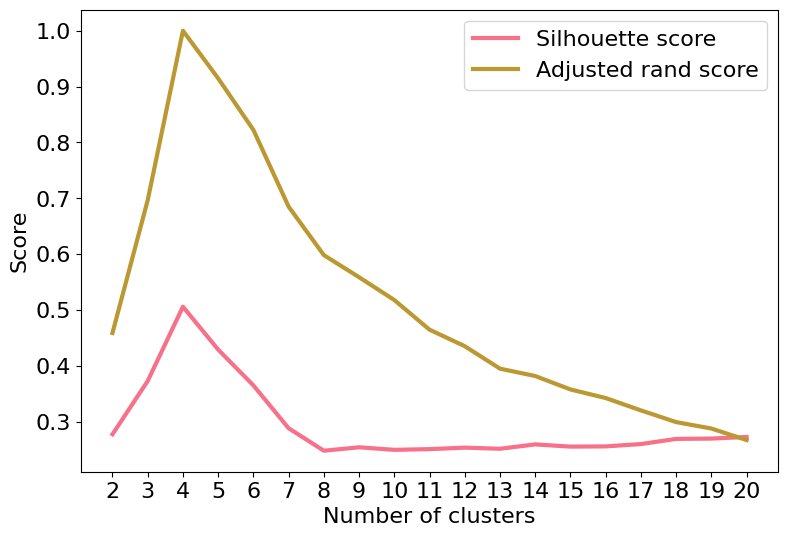

In [18]:
plt.figure(figsize=(9, 6))
plt.plot(n_clusters, silhouette_score_values, linewidth=3, label='Silhouette score')
plt.plot(n_clusters, adjusted_rand_score_values, linewidth=3, label='Adjusted rand score')
plt.xlabel('Number of clusters', size=16)
plt.ylabel('Score', size=16)
plt.xticks(n_clusters, size=16)
plt.yticks(size=16)
plt.legend(loc='best', fontsize=16)

plt.show()

# Иерархическая кластеризация


In [19]:
from scipy.cluster.hierarchy import linkage, dendrogram

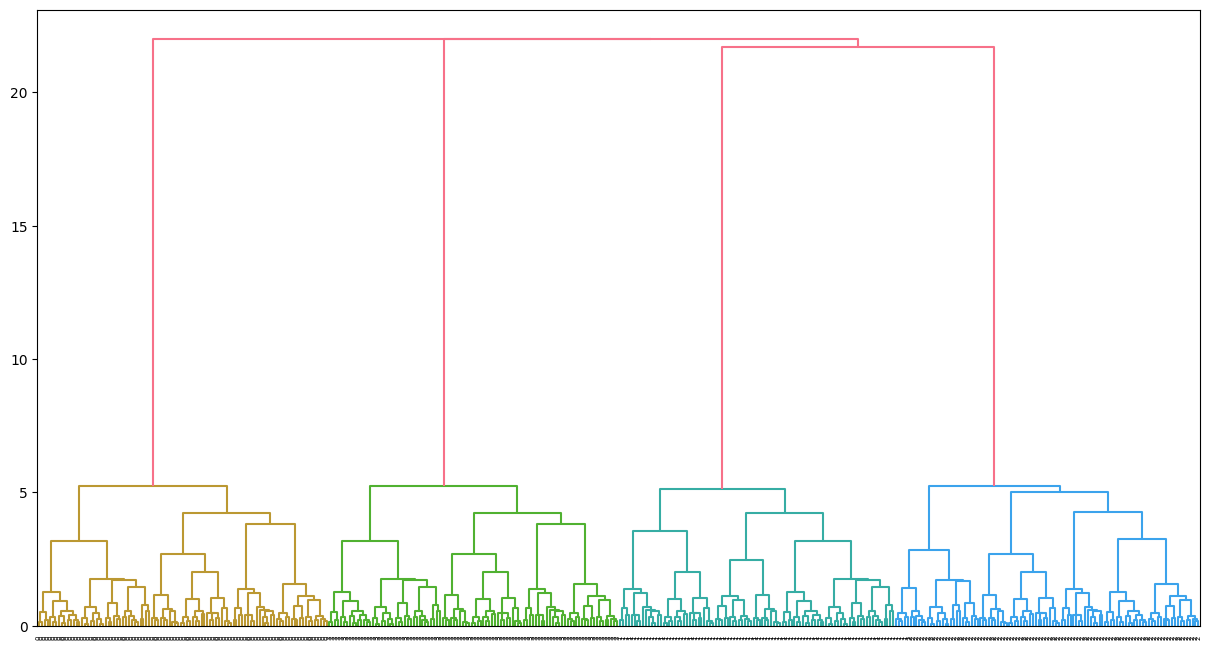

In [20]:
samples = df.values

# Реализация иерархической кластеризации при помощи функции linkage
mergings = linkage(samples, method='ward')

plt.figure(figsize=(15, 8))
# Строим дендрограмму, указав параметры удобные для отображения
dendrogram(mergings,
           labels=list(y),
           leaf_rotation=90,
           leaf_font_size=5,
           )

plt.show()

# DBSCAN


In [21]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn import datasets

In [22]:
mins = X.shape[1]

['y', 'b', 'g', 'r']


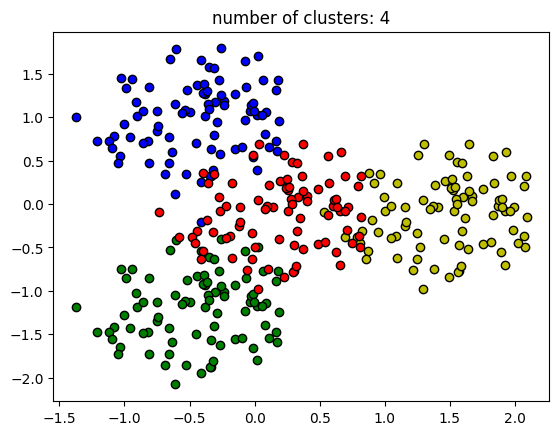

In [28]:
db = DBSCAN(eps=0.5, min_samples=12).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Число класстеров
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

unique_labels = set(labels)
colors = ['y', 'b', 'g', 'r']
print(colors)
for k, col in zip(unique_labels, colors):
	if k == -1:
		col = 'k'

	class_member_mask = (labels == k)

	xy = X[class_member_mask & core_samples_mask]
	plt.plot(xy["x"], xy["y"], 'o', markerfacecolor=col,
			markeredgecolor='k',
			markersize=6)

	xy = X[class_member_mask & ~core_samples_mask]
	plt.plot(xy["x"], xy["y"], 'o', markerfacecolor=col,
			markeredgecolor='k',
			markersize=6)

plt.title('number of clusters: %d' % n_clusters_)
plt.show()


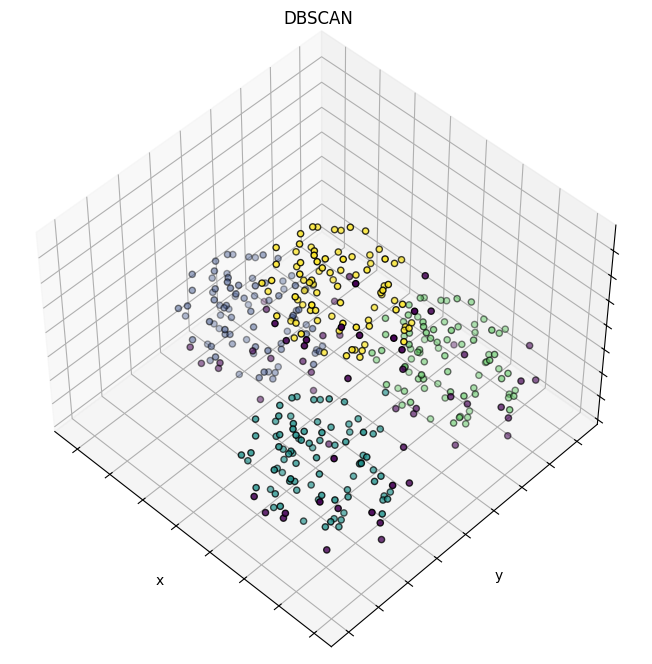

In [29]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection="3d", elev=48, azim=134)

ax.scatter(X["x"], X["y"], X["z"], c=labels.astype(float), edgecolor="k")

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_title("DBSCAN")

plt.show()

Для оценки алгоритмов кластеризации мы будем использовать оценку силуэта и оценку скорректированного рэнда. Оценка Silhouette находится в диапазоне от -1 до 1. Оценка около 1 означает, что точка данных i очень компактна в пределах кластера, к которому она принадлежит, и удалена от других кластеров. Худшее значение — -1. Значения, близкие к 0, обозначают перекрывающиеся кластеры.

Абсолютный показатель Rand Score находится в диапазоне от 0 до 1. Больше 0,9 означает отличное кластерное восстановление, а выше 0,8 — хорошее восстановление. Менее 0,5 считается плохим восстановлением.

In [30]:
# evaluation metrics
sc = metrics.silhouette_score(X, labels)
print("Silhouette Coefficient:%0.2f" % sc)
ari = adjusted_rand_score(y, labels)
print("Adjusted Rand Index: %0.2f" % ari)

Silhouette Coefficient:0.37
Adjusted Rand Index: 0.77
